<a href="https://colab.research.google.com/github/rheazh/Data-Analysis/blob/main/Unit_3_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Unit Three Project**

What is the average number of people who get struck by lightning in the United States every year?

**Prior**: I don't have much prior knowledge about the frequency of people getting struck by lightning, but I believe that it would be quite uncommon. Due to my lack of knowledge on the subject, I don't expect my prior to be very accurate or strong. I guess that out of the 345.4 million people that live in the United States currently, 150 people on average are struck by lightning each year.

**graphing the prior**

To visualize my initial guess, I created a normal distribution graph. I set the mean at 150, reflecting my estimate, and used a standard deviation of 100 to show my uncertainty. This graph helps to illustrate the range of possible outcomes based on my prior assumption.



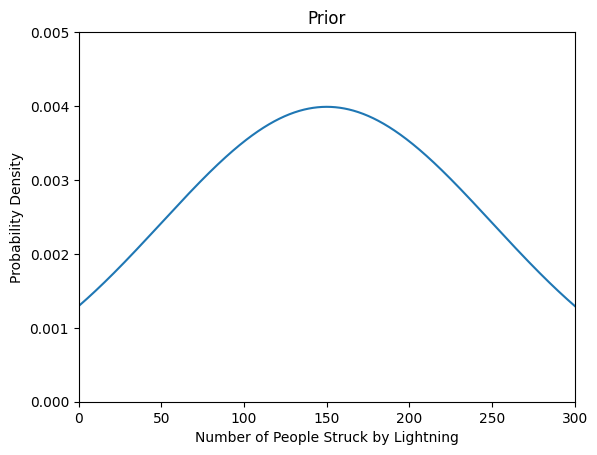

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm


mean = 150            # average (my guess)
std_dev = 100         # Standard deviation - reflects uncertainty

x_norm = np.linspace(0, 300, 1000)  # Generate 1000 points from 0 to 300

# Calculate the probability density function (PDF) for the normal distribution
pdf_norm = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_norm - mean) / std_dev) ** 2)

# Create a subplot for the normal distribution
plt.plot(x_norm, pdf_norm, label='Normal(μ=150, σ=100)')  # Plot
plt.title('Prior')
plt.xlim(0, 300)  # Set x-axis limits from 0 to 300
plt.ylim(0, 0.005)  # Set y-axis limits (small to see the graph better)
plt.xlabel('Number of People Struck by Lightning')  # Label x-axis
plt.ylabel('Probability Density')  # Label y-axis
plt.show()

I graphed the histogram of lightning strikes per a year in the past 23 years. The graph shows a positive skew with the average leaning more on the left side. There seems to be a variance from average of about 50 something.

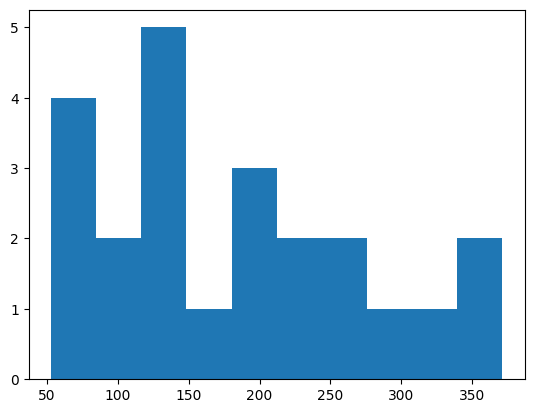

In [6]:
data_chemshift = [364, 371, 256, 237, 280, 309, 246, 138, 216, 201, 182, 187, 139, 145, 154, 130, 120, 86, 82, 100, 53, 69, 53]
plt.hist(data_chemshift)
plt.show()

I decided to use a gamma distribution mainly due to the right skew of my graph, the way my values are all positive, and because gamma distributions are quite flexible.

In [7]:
import pymc as pm
import numpy as np

data_chemshift = np.array([364, 371, 256, 237, 280, 309, 246, 138, 216, 201, 182, 187, 139, 145, 154, 130, 120, 86, 82, 100, 53, 69, 53])
with pm.Model() as model_chemshiftGamma:
    # Weak prior for shape parameter
    α = pm.Uniform('α', lower=1, upper=10)

    # Weak prior for scale parameter
    β = pm.HalfNormal('β', sigma=5)

    # New likelihood with gamma distribution
    y = pm.Gamma('y', alpha=α, beta=β, observed=data_chemshift)
    idata_chemshiftGamma = pm.sample()

Output()

Output()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>],
      dtype=object)

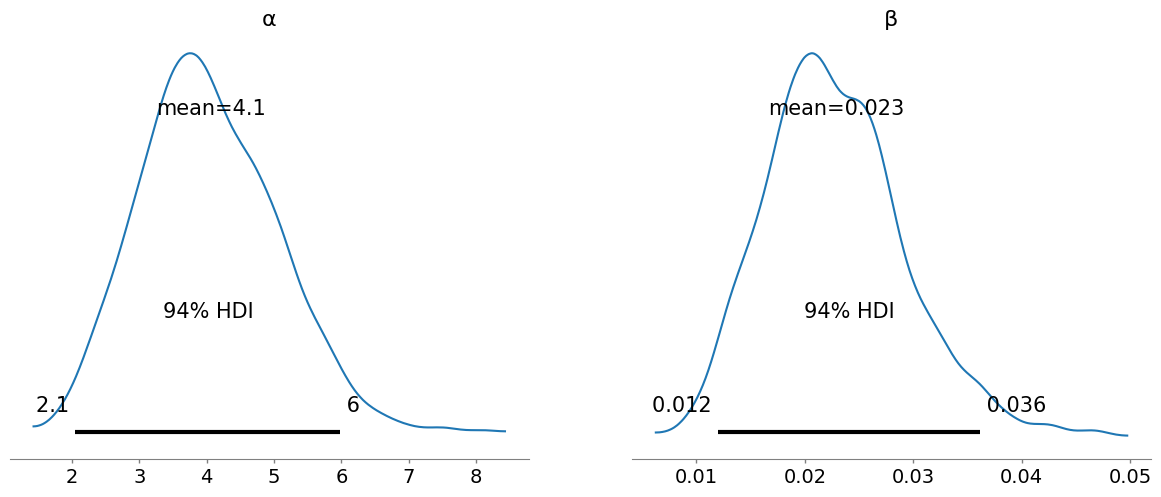

In [9]:
az.plot_posterior(idata_chemshiftGamma)

α is around 4, this suggests a moderate skew in the data, indicating that while most years have fewer strikes, the presence of high-strike years significantly influences the distribution.

since the value of β is relativley small, it suggests that the distribution is spread out and while the average is around 178, there can still be considerable variability around this average.
while there are many years near the mean there are also years way higher or lower than the mean.

In [10]:
pm.sample_posterior_predictive(idata_chemshiftGamma, model=model_chemshiftGamma, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

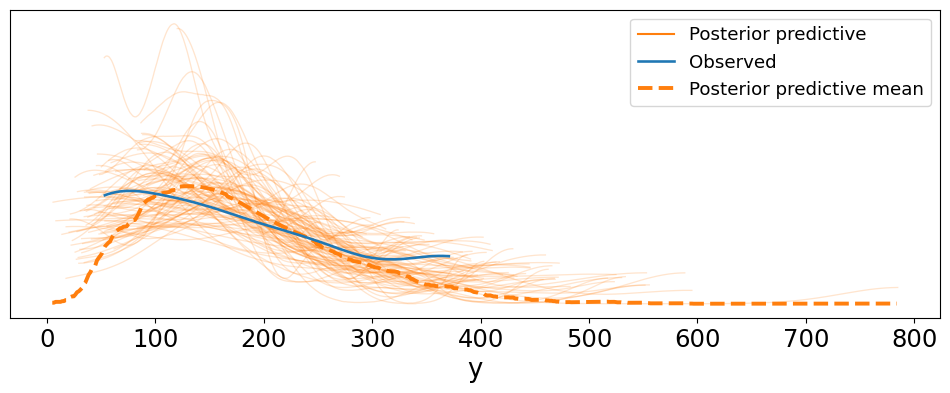

In [11]:
#Plots the posterior predictive density overlaid with a smoothed version of the data
az.plot_ppc(idata_chemshiftGamma, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

I thought that this one lined up alright but wanted to try another likelihood to see if I could find a better one.

In [16]:
with pm.Model() as model_chemshiftT:
    # Prior for the mean (μ)
    μ = pm.Uniform('μ', lower=53, upper=371)  # Based on your data range

    # HalfNormal prior for the scale parameter (σ)
    σ = pm.HalfNormal('σ', sigma=50)  # Adjust based on data variability

    # Degrees of freedom (ν) for the Student's t-distribution
    ν = pm.Exponential('ν', 1)  # Positive values, suggesting the shape of the distribution

    # Likelihood for the Student's t-distribution
    Y = pm.StudentT('Y', mu=μ, sigma=σ, nu=ν, observed=data_chemshift)

    # Sample from the model
    idata_chemshiftT = pm.sample()

Output()

Output()

In [17]:
pm.sample_posterior_predictive(idata_chemshiftT, model=model_chemshiftT, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

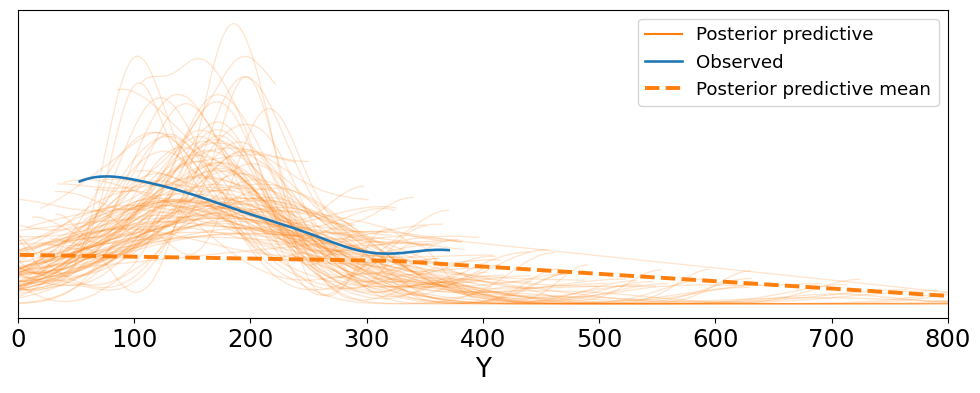

In [23]:
import arviz as az
import matplotlib.pyplot as plt

# Generate the PPC plot
az.plot_ppc(idata_chemshiftT, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

# Set the x-axis limits
plt.xlim(0, 800)  # Adjust the limits as needed

# Show the plot
plt.show()

I think that the Gamma distribution was definetly more visually accurate.

In [24]:
import pymc as pm
import numpy as np

data_chemshift = np.array([364, 371, 256, 237, 280, 309, 246, 138, 216, 201, 182, 187, 139, 145, 154, 130, 120, 86, 82, 100, 53, 69, 53])

with pm.Model() as model_chemshiftE:
    # Prior for the rate parameter (λ)
    λ = pm.HalfNormal('λ', sigma=10)  # λ must be positive

    # Likelihood for the Exponential distribution
    Y = pm.Exponential('Y', lam=λ, observed=data_chemshift)

    # Sample from the model
    idata_chemshiftE = pm.sample()

Output()

Output()

In [25]:
pm.sample_posterior_predictive(idata_chemshiftE, model=model_chemshiftE, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

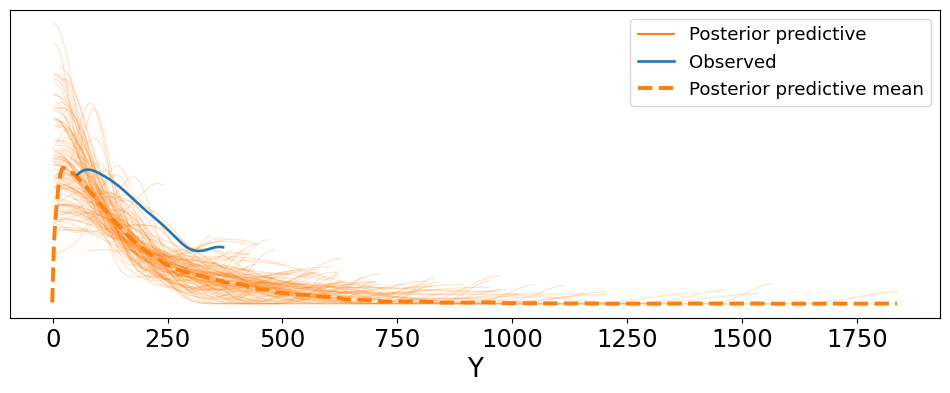

In [26]:
az.plot_ppc(idata_chemshiftE, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

After testing a few more likelihoods, I still decided that the Gamma distribution was the best match.

In [27]:
import numpy as np
import pymc as pm

alpha_samples = idata_chemshiftGamma.posterior['α'].values.flatten()
beta_samples = idata_chemshiftGamma.posterior['β'].values.flatten()

# Calculate the expected value for each sample
expected_values = alpha_samples / beta_samples

# Calculate the mean of the expected values
mean_estimate = np.mean(expected_values)

print("Estimated True Average:", mean_estimate)


Estimated True Average: 179.41559162979013
